# Homework 10 - Spatial Data Analysis
### Author Le Xu, lx565
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [5]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import pysal as ps
import shapely
import statsmodels.api as sm
import seaborn as sns
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [7]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [8]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)' %str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

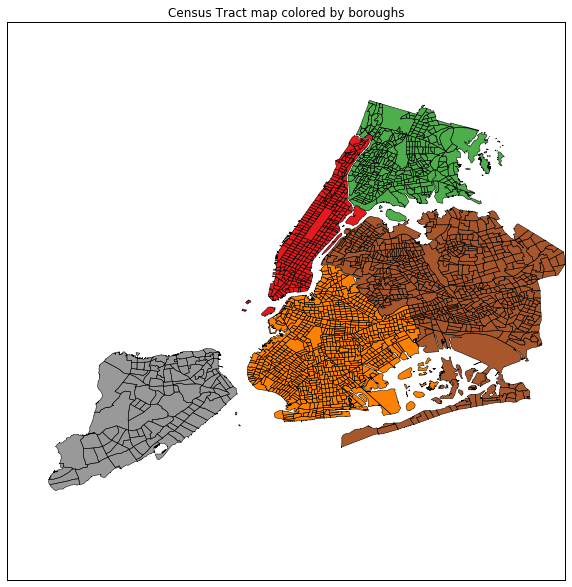

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha=1, linewidth=0.5, ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [10]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [11]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


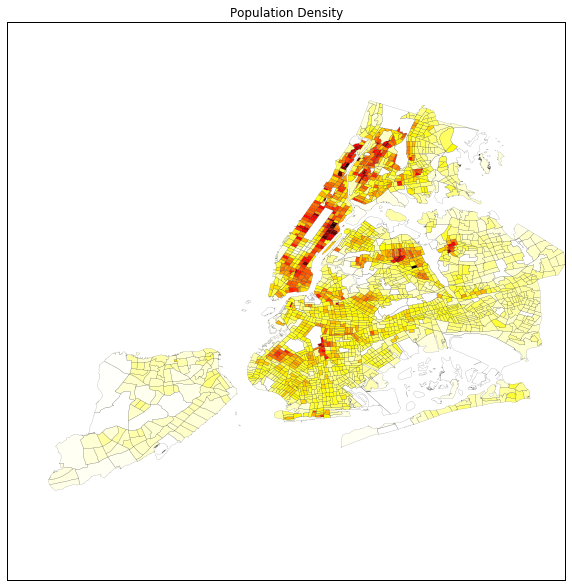

In [12]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column = 'SE_T002_002', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [144]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.index

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

## Get the summer months data (3 months) and winter months data (3 months)

In [145]:
#Get the summer month 7, 8, 9
df_bike_summer = df_bike_monthly[(df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month > 6)]
#Get the winter month 11, 12, 1
df_bike_winter = df_bike_monthly[(df_bike_monthly.index.month > 10) | (df_bike_monthly.index.month < 2)]

### Time Series Aanalysis

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


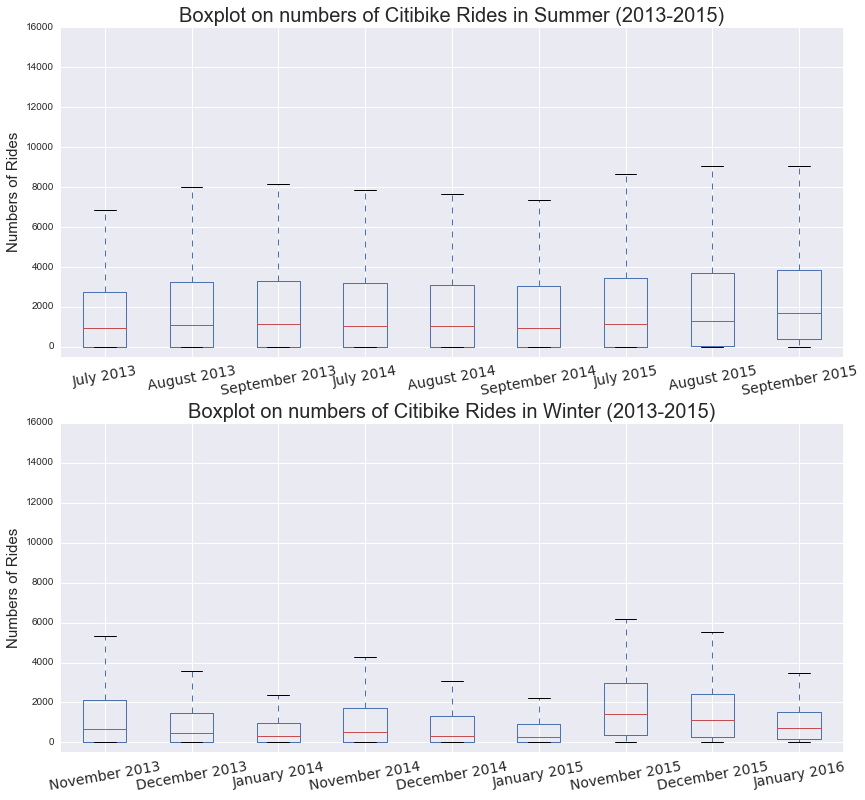

In [133]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(2,1,figsize = (14,13))
#create a copy of the df for the viz purposes
df_bike_summer_ = df_bike_summer.copy()
df_bike_winter_ = df_bike_winter.copy()
df_bike_summer_.index = df_bike_summer.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize = (15,7), ax = ax[0], rot=10)
df_bike_winter_.index = df_bike_winter.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize = (15,7), ax = ax[1], rot=10);
ax[0].set_ylim([-500,16000])
ax[1].set_ylim([-500,16000])
ax[0].set_ylabel("Numbers of Rides", fontsize = 15)
ax[1].set_ylabel("Numbers of Rides", fontsize = 15)
ax[0].set_title("Boxplot on numbers of Citibike Rides in Summer (2013-2015)", fontsize = 20)
ax[1].set_title("Boxplot on numbers of Citibike Rides in Winter (2013-2015)", fontsize = 20)


## The above 2 boxplot graphs, first one for Summer months (2013-2015) and second one for Winter months (2013-2015), the X axis represents the months and the Y axis represents the numbers of rides.  
###  Summer months plot : We can see a relatively flat trend of median for the year 2013 and 2014, and some evident increase on Sep 2015.
###  Winter months plot : We can see a $periodical$ decreasing trend of median through Nov to Jan from the year 2013 and 2016, which could be the weather drop. We can identify there are incresing medians for year 2015. 
### From both plots: We can see that Year 2015's the overall rides were increasing. 

#### Seasonal Decomposition for Summer

In [189]:
df_bike_monthly = df_bike_summer

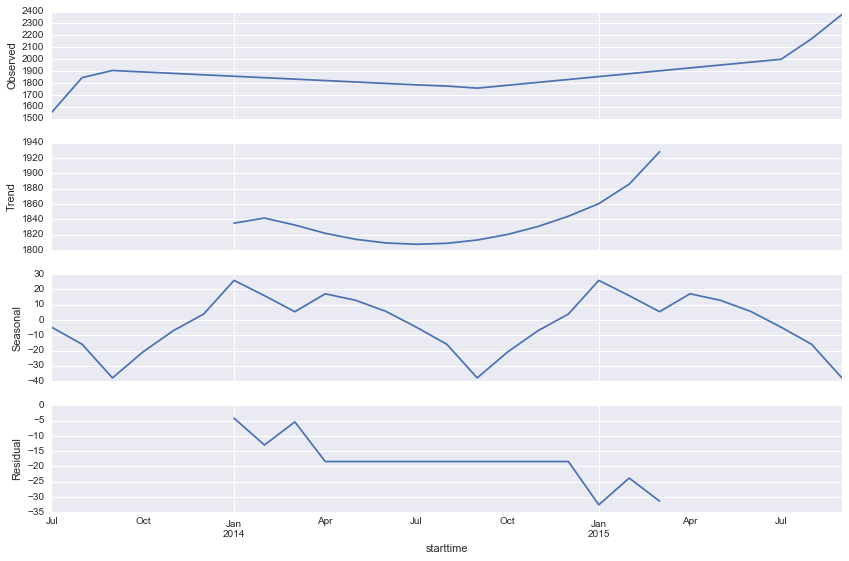

In [190]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

#### Seasonal Decomposition for Winter

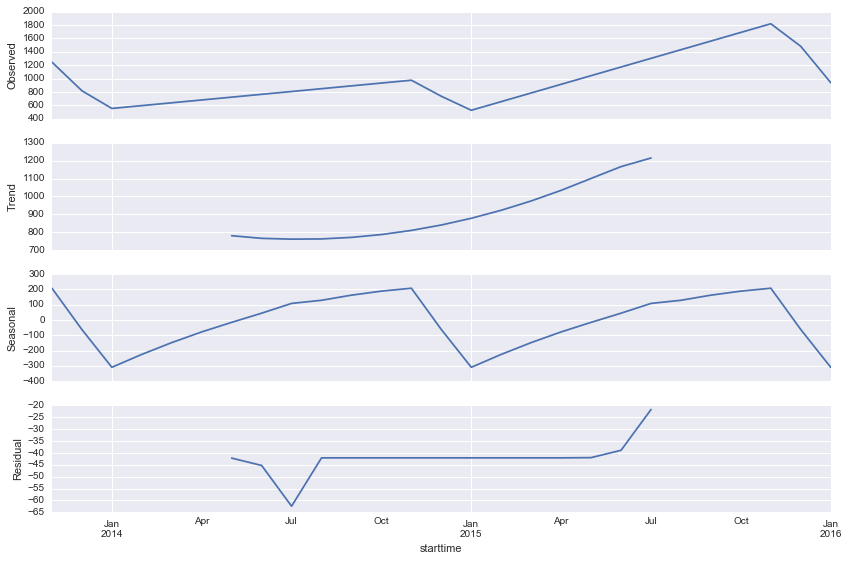

In [192]:
df_bike_monthly = df_bike_winter

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [193]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [194]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [195]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [196]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Summer and Winter rides to the station GeoDataFrame with CT code

In [197]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['SummerAve'] = df_bike_summer.sum()
station_id['WinterAve'] = df_bike_winter.sum()

In [198]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22940,12622
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,35290,16148
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,89624,47754
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33287,18568
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,62215,30739


### Add the Summer and Winter average rides to the CT shapefile 

In [203]:
temp = station_id[['SummerAve','WinterAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


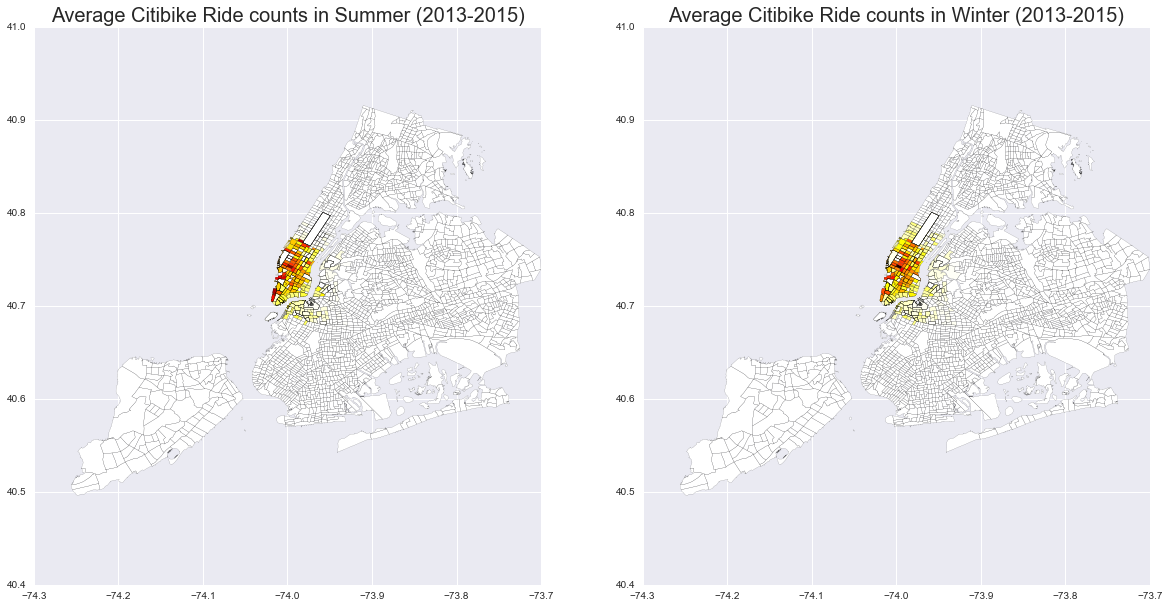

In [206]:
f, ax = plt.subplots(1,2, figsize = (20,10))
ax1 = ct_shape_MonthlyAve.plot(column = 'SummerAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax[0])
ax2 = ct_shape_MonthlyAve.plot(column = 'WinterAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax[1])

ax1.set_title("Average Citibike Ride counts in Summer (2013-2015)", fontsize = 20)
ax2.set_title("Average Citibike Ride counts in Winter (2013-2016)", fontsize = 20)



### Removing the CTs that are out of zoom boundries

In [207]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x >- 74.1 and c.x <- 73.92 and c.y > 40.65 and c.y < 40.8)])

In [211]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.SummerAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

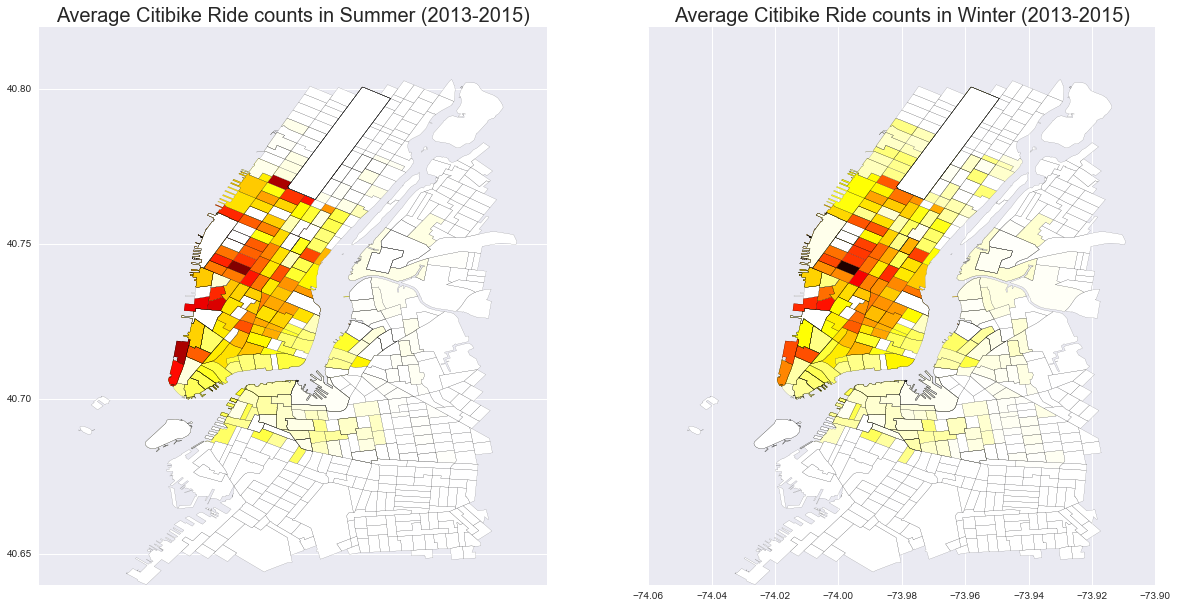

In [218]:
f, ax = plt.subplots(1, 2, figsize = (20,10))
ax1 = ct_shape_MonthlyAve_Zoom.plot(column = 'SummerAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax[0])
ax2 = ct_shape_MonthlyAve_Zoom.plot(column = 'WinterAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax[1])
ax1.set_title("Average Citibike Ride counts in Summer (2013-2015)", fontsize = 20)
ax2.set_title("Average Citibike Ride counts in Winter (2013-2016)", fontsize = 20)
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)



### Export Shapefile CTs in the CitiBike Zone

In [219]:
path = 'Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [221]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [222]:
qW_CT[3]

{1: 1.0,
 2: 1.0,
 4: 1.0,
 24: 1.0,
 26: 1.0,
 27: 1.0,
 30: 1.0,
 426: 1.0,
 427: 1.0,
 428: 1.0,
 429: 1.0,
 430: 1.0}

In [223]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [224]:
Wmatrix, ids = qW_CT.full()

In [225]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [226]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [227]:
SummerMonthlyRide = ct_shape_MonthlyAve_Zoom.SummerAve
WinterMonthlyRide = ct_shape_MonthlyAve_Zoom.WinterAve
SummerMonthlyRideLag = ps.lag_spatial(qW_CT, SummerMonthlyRide)
WinterMonthlyRideLag = ps.lag_spatial(qW_CT, WinterMonthlyRide)

#### Create Quantiles for maping

In [230]:
SummerMonthlyRideLagQ10 = ps.Quantiles(SummerMonthlyRideLag, k = 10)
WinterMonthlyRideLagQ10 = ps.Quantiles(WinterMonthlyRideLag, k = 10)
SummerMonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               161
    0.000 < x[i] <=   696.661                78
  696.661 < x[i] <=  1803.750                80
 1803.750 < x[i] <=  4727.424                79
 4727.424 < x[i] <=  8447.733                80
 8447.733 < x[i] <= 19124.965                79
19124.965 < x[i] <= 28039.143                80
28039.143 < x[i] <= 32246.317                79
32246.317 < x[i] <= 48706.786                80

In [229]:
WinterMonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    45.429                 2
   45.429 < x[i] <=   763.792                78
  763.792 < x[i] <=  1903.583                80
 1903.583 < x[i] <=  3025.970                79
 3025.970 < x[i] <=  4383.619                80
 4383.619 < x[i] <= 10166.268                79
10166.268 < x[i] <= 13938.130                80
13938.130 < x[i] <= 16783.186                79
16783.186 < x[i] <= 26923.429                80

#### Map the summer and winter rides lag

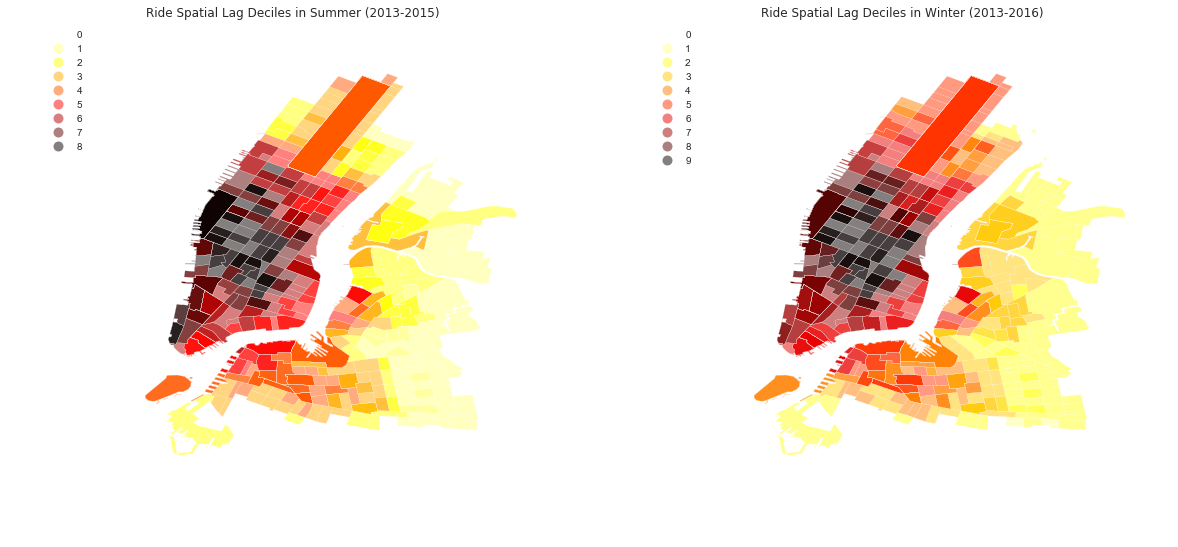

In [232]:
f, ax = plt.subplots(1, 2, figsize=(20, 9))
ax1 = ct_shape_MonthlyAve_Zoom.assign(cl = SummerMonthlyRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap ='hot_r', linewidth = 0.1, ax = ax[0], 
        edgecolor ='white', legend = True)
ax2 = ct_shape_MonthlyAve_Zoom.assign(cl = WinterMonthlyRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap ='hot_r', linewidth = 0.1, ax = ax[1], 
        edgecolor ='white', legend = True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Ride Spatial Lag Deciles in Summer (2013-2015)")
ax2.set_title("Ride Spatial Lag Deciles in Winter (2013-2016)")

## Global  Spatial Autocorrelation

In [234]:
b_summer,a_summer = np.polyfit(SummerMonthlyRide, SummerMonthlyRideLag, 1)
b_summer,a_summer 

(0.62926871704725484, 4329.293572160489)

In [235]:
b_winter,a_winter = np.polyfit(WinterMonthlyRide, WinterMonthlyRideLag, 1)
b_winter,a_winter 

(0.65791812867838539, 2135.4380123777764)

### Moran Scatterplot

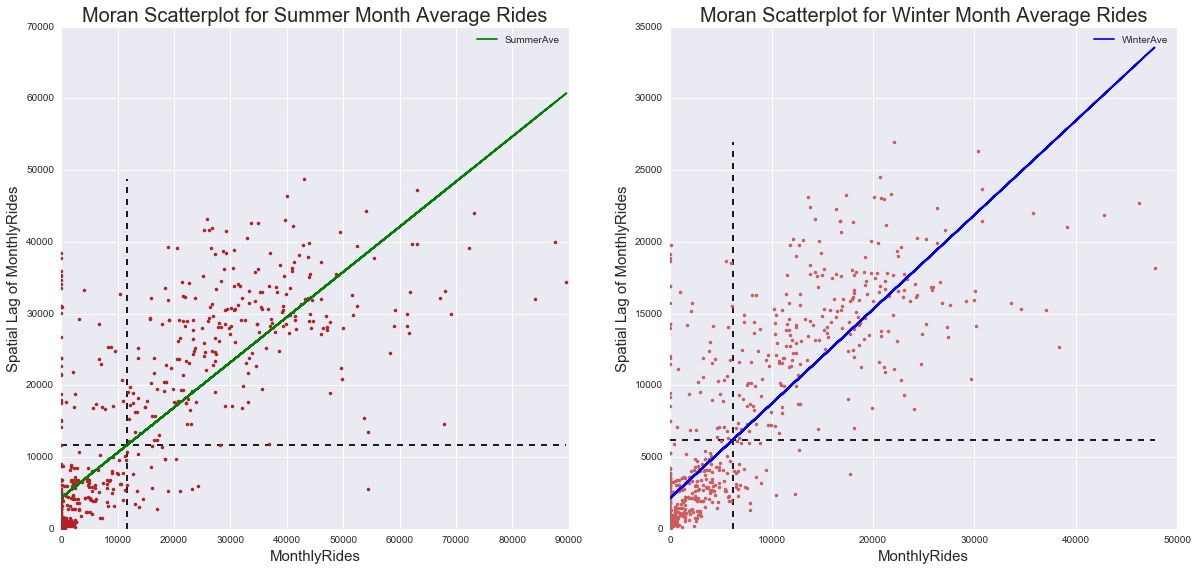

In [262]:
f, ax = plt.subplots(1, 2, figsize = (20, 9))

ax[0].plot(SummerMonthlyRide, SummerMonthlyRideLag, '.', color = 'firebrick')
ax[1].plot(WinterMonthlyRide, WinterMonthlyRideLag, '.', color = 'Indianred')
 # dashed vert at mean of the last year's PCI
ax[0].vlines(SummerMonthlyRide.mean(), SummerMonthlyRideLag.min(), SummerMonthlyRideLag.max(), linestyle = '--')
ax[1].vlines(WinterMonthlyRide.mean(), WinterMonthlyRideLag.min(), WinterMonthlyRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
ax[0].hlines(SummerMonthlyRideLag.mean(), SummerMonthlyRide.min(), SummerMonthlyRide.max(), linestyle = '--')
ax[1].hlines(WinterMonthlyRideLag.mean(), WinterMonthlyRide.min(), WinterMonthlyRide.max(), linestyle = '--')


# red line of best fit using global I as slope
ax[0].plot(SummerMonthlyRide, a_summer + b_summer*SummerMonthlyRide, 'g')
ax[1].plot(WinterMonthlyRide, a_winter + b_winter*WinterMonthlyRide, 'b')


ax[0].set_title('Moran Scatterplot for Summer Month Average Rides', fontsize = 20)
ax[1].set_title('Moran Scatterplot for Winter Month Average Rides', fontsize = 20)
ax[0].set_ylabel('Spatial Lag of MonthlyRides', fontsize = 15)
ax[1].set_ylabel('Spatial Lag of MonthlyRides', fontsize = 15)
ax[0].set_xlabel('MonthlyRides', fontsize = 15)
ax[1].set_xlabel('MonthlyRides', fontsize = 15)
ax[0].legend(["Summer Average"])
ax[1].legend(["Winter Average"])


### Moran's I for summer

In [274]:
I_SummerMonthlyRide = ps.Moran(SummerMonthlyRide, qW_CT)

In [275]:
I_SummerMonthlyRide.I, I_SummerMonthlyRide.p_sim

(0.62946359212848402, 0.001)

Thus, the $I$ statistic is $0.629$ for Summer months data, and has a very small $p$ value. 

In [280]:
I_MonthlyRide.sim[0:10]

array([-0.01263844,  0.01324278,  0.01408435,  0.0085103 , -0.00764153,
        0.02597593, -0.00541744, -0.00522896,  0.01458207,  0.00426166])

### Moran's I for winter

In [283]:
I_WinterMonthlyRide = ps.Moran(WinterMonthlyRide, qW_CT)

In [284]:
I_WinterMonthlyRide.I, I_WinterMonthlyRide.p_sim

(0.65807911213278847, 0.001)

Thus, the $I$ statistic is $0.658$ for Winter months data, and has a very small $p$ value. 

In [286]:
I_WinterMonthlyRide.sim[0:10]

array([ 0.00932705,  0.02549472,  0.00788985, -0.01830086, -0.00631842,
       -0.01768781, -0.00780584, -0.01276125,  0.01053265,  0.00235201])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [287]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (14,3)

### Summer:

(-0.7, 0.7)

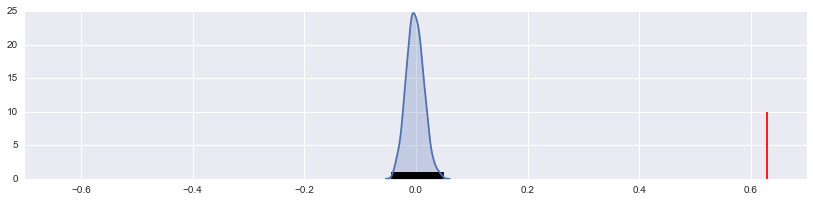

In [288]:
sns.kdeplot(I_SummerMonthlyRide.sim, shade = True)
plt.vlines(I_SummerMonthlyRide.sim, 0, 1)
plt.vlines(I_SummerMonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

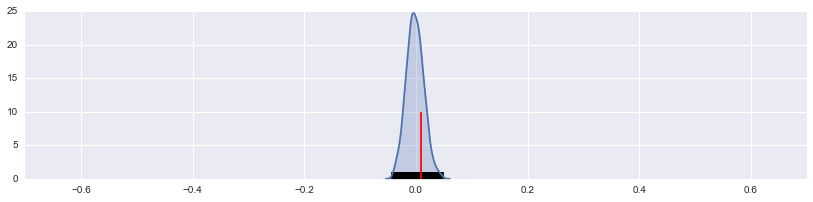

In [290]:
sns.kdeplot(I_SummerMonthlyRide.sim, shade = True)
plt.vlines(I_SummerMonthlyRide.sim, 0, 1)
plt.vlines(I_SummerMonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

### Winter:

(-0.7, 0.7)

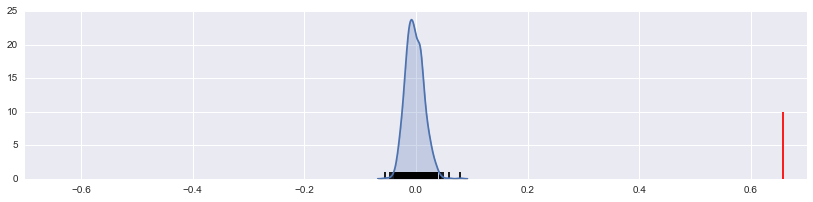

In [289]:
sns.kdeplot(I_WinterMonthlyRide.sim, shade = True)
plt.vlines(I_WinterMonthlyRide.sim, 0, 1)
plt.vlines(I_WinterMonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

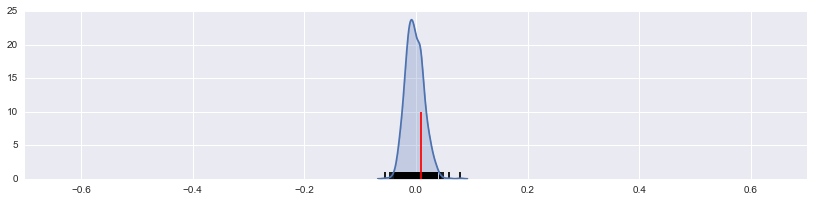

In [291]:
sns.kdeplot(I_WinterMonthlyRide.sim, shade = True)
plt.vlines(I_WinterMonthlyRide.sim, 0, 1)
plt.vlines(I_WinterMonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [292]:
# summer
LMo_SummerMonthlyRide = ps.Moran_Local(SummerMonthlyRide, qW_CT, permutations = 999)

In [293]:
LMo_SummerMonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.23326927,  0.01313014,  0.00869015,  0.0278383 ]),
 array([ 0.001,  0.144,  0.468,  0.499,  0.41 ]))

In [294]:
# winter
LMo_WinterMonthlyRide = ps.Moran_Local(WinterMonthlyRide, qW_CT, permutations = 999)

In [295]:
LMo_WinterMonthlyRide.Is[0:5], LMo_SummerMonthlyRide.p_sim[0:5]

(array([-0.        , -0.28144544,  0.00132628, -0.00265961, -0.06467646]),
 array([ 0.001,  0.178,  0.366,  0.369,  0.348]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [308]:
#summer
sigs_summer = SummerMonthlyRide[LMo_SummerMonthlyRide.p_sim <= .001]
W_sigs_summer = SummerMonthlyRideLag[LMo_SummerMonthlyRide.p_sim <= .001]
insigs_summer = SummerMonthlyRide[LMo_SummerMonthlyRide.p_sim > .001]
W_insigs_summer = SummerMonthlyRideLag[LMo_SummerMonthlyRide.p_sim > .001]

In [340]:
# winter
sigs_w = WinterMonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs_w = WinterMonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs_w = WinterMonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs_w = WinterMonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

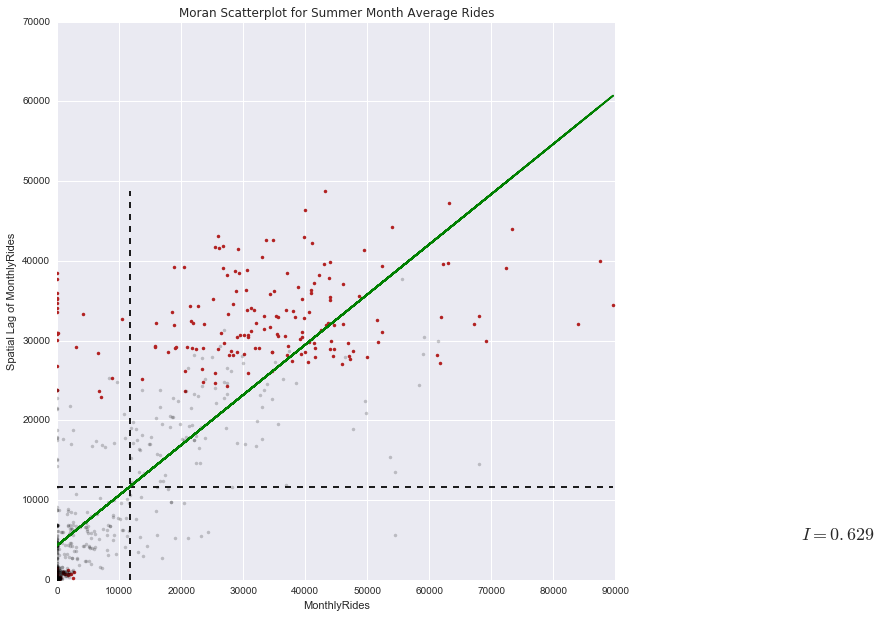

In [341]:
f, ax = plt.subplots(figsize = (10, 10))
plt.plot(sigs_summer, W_sigs_summer, '.', color = 'firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha =.2)
plt.text(s='$I = %.3f$' % I_SummerMonthlyRide.I, x = 120000, y = 5000, fontsize = 18)
plt.vlines(SummerMonthlyRide.mean(), SummerMonthlyRideLag.min(), SummerMonthlyRideLag.max(), linestyle = '--')
plt.hlines(SummerMonthlyRideLag.mean(), SummerMonthlyRide.min(), SummerMonthlyRide.max(), linestyle = '--')
plt.plot(SummerMonthlyRide, a_summer + b_summer*SummerMonthlyRide, 'g')
plt.title('Moran Scatterplot for Summer Month Average Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

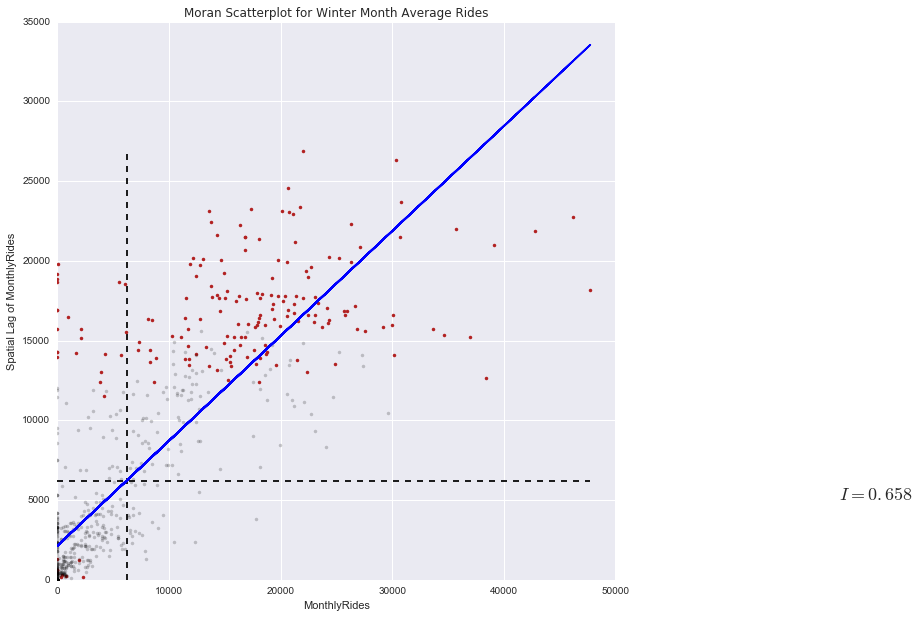

In [342]:
f, ax = plt.subplots(figsize = (10, 10))

plt.plot(sigs_w, W_sigs_w, '.', color = 'firebrick')
plt.plot(insigs_w, W_insigs_w, '.k', alpha = .2)
plt.text(s='$I = %.3f$' % I_WinterMonthlyRide.I, x = 70000, y = 5000, fontsize = 18)

plt.vlines(WinterMonthlyRide.mean(), WinterMonthlyRideLag.min(), WinterMonthlyRideLag.max(), linestyle = '--')
plt.hlines(WinterMonthlyRideLag.mean(), WinterMonthlyRide.min(), WinterMonthlyRide.max(), linestyle = '--')


# red line of best fit using global I as slope
plt.plot(WinterMonthlyRide, a_winter + b_winter*WinterMonthlyRide, 'b')
plt.title('Moran Scatterplot for Winter Month Average Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Hot and Cold spots 

In [343]:
# summer
sig = LMo_SummerMonthlyRide.p_sim < 0.01
hotspots_s = LMo_SummerMonthlyRide.q == 1 * sig
coldspots_s = LMo_SummerMonthlyRide.q == 3 * sig
print "Number of Hotspots:", hotspots_s.sum()
print "Number of Coldspots:", coldspots_s.sum()

Number of Hotspots: 187
Number of Coldspots: 214


In [344]:
#winter
sig = LMo_WinterMonthlyRide.p_sim < 0.01
hotspots_w = LMo_WinterMonthlyRide.q == 1 * sig
coldspots_w = LMo_WinterMonthlyRide.q == 3 * sig
print "Number of Hotspots:", hotspots_w.sum()
print "Number of Coldspots:", coldspots_w.sum()

Number of Hotspots: 192
Number of Coldspots: 204


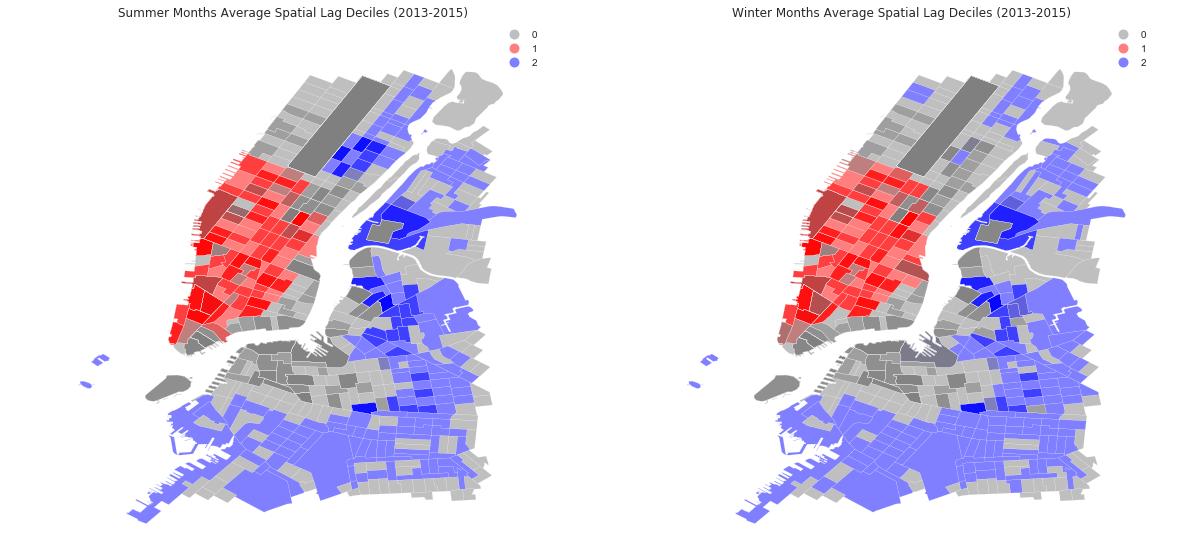

In [345]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_s = hotspots_s*1 + coldspots_s*2
hotcold_w = hotspots_w*1 + coldspots_w*2
f, ax = plt.subplots(1, 2, figsize = (20, 9))
ax1 = ct_shape_MonthlyAve_Zoom.assign(cl = hotcold_s).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax[0], 
        edgecolor = 'white', legend = True)
ax1.set_axis_off()
ax1.set_title("Summer Months Average Spatial Lag Deciles (2013-2015)")

ax2 = ct_shape_MonthlyAve_Zoom.assign(cl = hotcold_w).plot(column = 'cl', categorical = True, 
        k= 10, cmap = hcmap, linewidth = 0.1, ax = ax[1], 
        edgecolor ='white', legend = True)
ax2.set_axis_off()
ax2.set_title("Winter Months Average Spatial Lag Deciles (2013-2015)")

